# DATASET

#### ISIC dataset is a large collection of dermatoscopic images of nine  different diagnostic categories.

About Melanoma
Skin cancer is a major public health problem, with over 5,000,000 newly diagnosed cases in the United States every year. Melanoma is the deadliest form of skin cancer, responsible for an overwhelming majority of skin cancer deaths. In 2015, the global incidence of melanoma was estimated to be over 350,000 cases, with almost 60,000 deaths. Although the mortality is significant, when detected early, melanoma survival exceeds 95%.

The ISIC dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from The International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

1. actinic keratosis
2. basal cell carcinoma
3. dermatofibroma
4. melanoma
5. nevus
6. pigmented benign keratosis
7. seborrheic keratosis
8. squamous cell carcinoma
9. vascular lesion




# DECLARE VARIABLES

In [ ]:
import pickle # enable the saving and loading of trained models for later use
#from google.colab import files # load data to colab
import pathlib
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# load data to colab
from google.colab import files
import os
import cv2
import PIL
import glob
from tensorflow import keras

from keras.models import Sequential, load_model
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.utils import image_dataset_from_directory #Generates a tf.data.Dataset from image files in a directory.
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, Input, BatchNormalization, Rescaling
from tensorflow.keras.applications import EfficientNetB2, DenseNet201, DenseNet121, Xception, VGG19
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from imblearn.under_sampling import RandomUnderSampler
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import SGD


# Transform features by scaling each feature to a given range.
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
#Pipeline of transforms with a final estimator.
from sklearn.pipeline import Pipeline

#Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

#train_test_split function
from sklearn.model_selection import train_test_split

# DOWNLOAD DATA

In [ ]:
#install kaggle
#!pip install -q kaggle # install kaggle API to download datasets

In [ ]:
#Load the kaggle token saved as json file to collab
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:

!mkdir -p ~/.kaggle  # create directory called kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/  # copy the .json file to the directory
!chmod 600 ~/.kaggle/kaggle.json  # set access control for this credential file


In [ ]:
# access google drive for creating a folder
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive'

#!mkdir Advanced_AI
%cd '/content/drive/My Drive/Advanced_AI'

Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive/Advanced_AI


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Advanced_AI/kaggle.json"
!ls "/content/drive/MyDrive/Advanced_AI/kaggle.json"

kaggle.json


In [ ]:
#Download dataset and unzip
!kaggle datasets download -d rajatvisitme/skin-cancer-isic --force
#unzip data
#!unzip '/content/drive/My Drive/Advanced_AI/skin-cancer9-classesisic.zip'

100% 784M/785M [00:46<00:00, 21.7MB/s]
100% 785M/785M [00:46<00:00, 17.7MB/s]


In [ ]:
#unzip data
#!unzip '/content/drive/My Drive/Advanced_AI/skin-cancer-isic.zip'

*****Make sure to rename the folder after it has downloaded to "ISIC DATA"****

# Load Data

In [ ]:
# Defining the path for train and test images
import pathlib
data_dir_train = pathlib.Path("./skin_cancer_ISIC/Train/")
data_dir_test = pathlib.Path("./skin_cancer_ISIC/Test/")

In [ ]:
#Store the images as array

img_data = []
label = []

IMG_HEIGHT = 299
IMG_WIDTH = 299

for i in os.listdir(data_dir_train):
    impath = os.path.join(data_dir_train,i)
    im = glob.glob(impath + '/*.jpg')
    print(len(im))
    for j in im:
        img= cv2.imread(j)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_LANCZOS4)
        img = cv2.GaussianBlur(img, (3,3), 0)
        edges = cv2.Canny(img, 50, 150)

        img=np.array(img)
        img = img.astype('float32')
        img_data.append(img)
        label.append(i)

114
376
95
438
357
462
77
181
139


In [ ]:
len(img_data)

2239

In [ ]:
len(label)

2239

In [ ]:
vals, ids, y = np.unique(label, return_index=True, return_inverse=True)
print(vals)
print(y)

['actinic keratosis' 'basal cell carcinoma' 'dermatofibroma' 'melanoma'
 'nevus' 'pigmented benign keratosis' 'seborrheic keratosis'
 'squamous cell carcinoma' 'vascular lesion']
[0 0 0 ... 8 8 8]


# visualization

1421
183
66
840
1660
1935
1211
1956
54


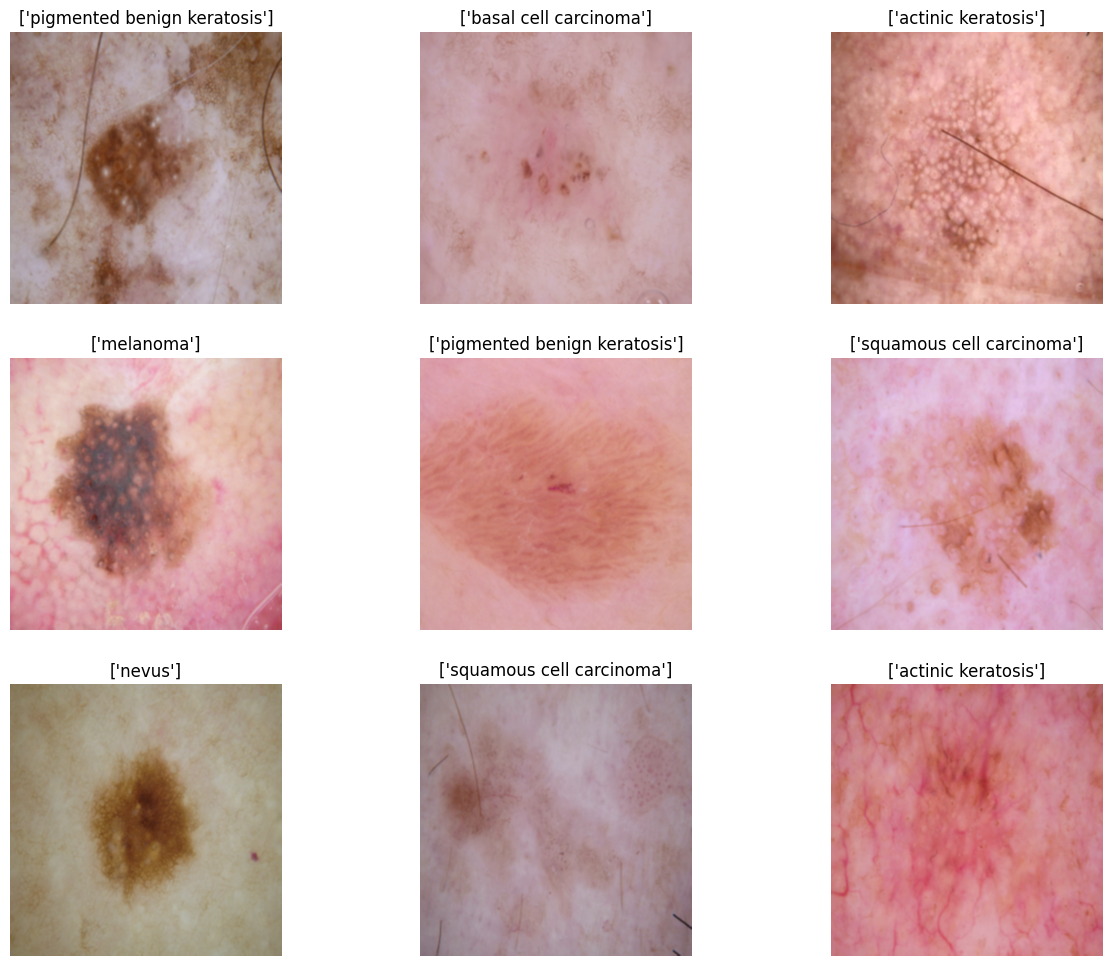

In [ ]:
# visualize images loaded with the keras utility (image_dataset_from_directory)

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

for i in range(9):
    num=random.randint(0,2239)
    print(num)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img_data[num].astype("uint8"))
    plt.title([label[num]])
    plt.axis("off")

In [ ]:
"""datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')"""

"datagen = ImageDataGenerator(\n    rotation_range=20,\n    width_shift_range=0.2,\n    height_shift_range=0.2,\n    shear_range=0.2,\n    zoom_range=0.2,\n    horizontal_flip=True,\n    fill_mode='nearest')"

# Data Split

In [ ]:
#Split dataset into 80% training 20% others
X_train, X_others, y_train, y_others = train_test_split(img_data, y, test_size=0.3, random_state=0, stratify=y)
#Split dataset into 50% training 50% testig
X_valid, X_test, y_valid, y_test = train_test_split(X_others, y_others, test_size=0.5, random_state=0, stratify=y_others)



In [ ]:
#reshaping for cnn
# defining the sets of train and test
X_train = np.array(X_train).reshape(-1, 299,299, 3)
X_valid = np.array(X_valid).reshape(-1, 299,299, 3)
X_test = np.array(X_test).reshape(-1, 299,299, 3)
X_train /= 255
X_valid/=255
X_test /= 255

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(1567, 299, 299, 3)
(336, 299, 299, 3)
(336, 299, 299, 3)
(1567,)
(336,)
(336,)


normalisation

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Reshape the input data to 2D
n_samples, height, width, channels = X_train.shape
X_train_2d = X_train.reshape((n_samples, height * width * channels))

# Apply random undersampling to the training data
sampler = RandomUnderSampler(random_state=42)
X_train_resampled_2d, y_train_resampled = sampler.fit_resample(X_train_2d, y_train)

# Reshape the resampled data back to its original shape
X_train_resampled = X_train_resampled_2d.reshape((-1, height, width, channels))


label encoding

In [ ]:
""" #save to folder for future use
dfX = pd.DataFrame(X_train)
dfX.to_csv('X_train.csv')
dfy = pd.DataFrame(y_train)
dfy.to_csv('y_train.csv')
dfX = pd.DataFrame(X_valid)
dfy.to_csv('y_valid.csv')
dfy = pd.DataFrame(y_valid)
dfy.to_csv('y_valid.csv')
dfX = pd.DataFrame(X_test)
dfX.to_csv('X_test.csv')
dfy = pd.DataFrame(y_test)
dfy.to_csv('y_test.csv') """

" #save to folder for future use\ndfX = pd.DataFrame(X_train)\ndfX.to_csv('X_train.csv') \ndfy = pd.DataFrame(y_train)\ndfy.to_csv('y_train.csv')\ndfX = pd.DataFrame(X_valid)\ndfy.to_csv('y_valid.csv')\ndfy = pd.DataFrame(y_valid)\ndfy.to_csv('y_valid.csv')\ndfX = pd.DataFrame(X_test)\ndfX.to_csv('X_test.csv') \ndfy = pd.DataFrame(y_test)\ndfy.to_csv('y_test.csv') "

# TRANSFER LEARNING

Freeze all layers, except the last layer of the network

XCEPTION!

You can try others specified in the file.



In [ ]:
base = tf.keras.applications.Xception(include_top=False,weights="imagenet", input_shape=X_train[0].shape)
base.trainable = False #can change this to true to train the last conv layer.
base.summary()

#data_aug = keras.Sequential([preprocessing.RandomContrast(factor=0.2), preprocessing.RandomRotation(factor=0.15), preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),preprocessing.RandomFlip()], name= "aug")

83683744/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [ ]:
"""num_classes = 9
input_shape = X_train[0].shape
inputs = Input(shape=input_shape)
x = base(inputs)
x = Conv2D(32, 3,  input_shape=input_shape, activation='relu')(x)
x = MaxPooling2D(4,4)(x)

x = Flatten()(x)

# At this point you can apply MLP level of redisign
x = Dense(500, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation ='softmax')(x)
model = Model(inputs=inputs, outputs=x)
model.summary()"""

from tensorflow.keras import regularizers

num_classes = 9
input_shape = X_train[0].shape

inputs = Input(shape=input_shape)
x = base(inputs)
x = Conv2D(32, 3, input_shape=input_shape, activation='relu')(x)
x = MaxPooling2D(4, 4)(x)
x = Flatten()(x)

# Add L2 regularization to the dense layers
x = Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)

model = Model(inputs=inputs, outputs=x)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 32)          589856    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 32)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 500)               64500     
                                                             

In [ ]:
# compiling the model
opt = tf.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
aug = ImageDataGenerator(rotation_range=10,horizontal_flip=True)

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=3,          # number of epochs with no improvement
    restore_best_weights=True  # restore the weights from the epoch with the best value of the monitored metric
)

In [ ]:
history = model.fit(X_train, y_train, batch_size=48, epochs=35, validation_data=(X_valid, y_valid), callbacks=[early_stopping])

Epoch 1/35
33/33 [==============================] - 34s 515ms/step - loss: 4.2343 - accuracy: 0.2138 - val_loss: 3.9788 - val_accuracy: 0.3274
Epoch 2/35
33/33 [==============================] - 12s 376ms/step - loss: 3.8266 - accuracy: 0.3612 - val_loss: 3.6924 - val_accuracy: 0.4137
Epoch 3/35
33/33 [==============================] - 13s 382ms/step - loss: 3.5405 - accuracy: 0.4429 - val_loss: 3.4965 - val_accuracy: 0.4494
Epoch 4/35
33/33 [==============================] - 13s 387ms/step - loss: 3.2949 - accuracy: 0.5105 - val_loss: 3.3617 - val_accuracy: 0.4464
Epoch 5/35
33/33 [==============================] - 13s 394ms/step - loss: 3.0577 - accuracy: 0.5833 - val_loss: 3.2365 - val_accuracy: 0.4851
Epoch 6/35
33/33 [==============================] - 13s 404ms/step - loss: 2.9006 - accuracy: 0.6101 - val_loss: 3.1287 - val_accuracy: 0.4762
Epoch 7/35
33/33 [==============================] - 13s 402ms/step - loss: 2.7071 - accuracy: 0.6624 - val_loss: 3.1490 - val_accuracy: 0.4375

In [ ]:
# save the model to disk FOR LATER USE
filename = 'xception.h5'
model.save(filename)
print(filename)

xception.h5


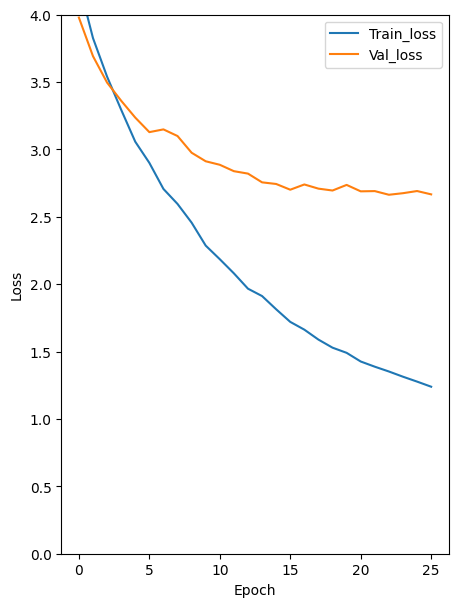

In [ ]:
plt.rcParams["figure.figsize"] = (5,7)
plt.plot(history.history['loss'], label='Train_loss')
plt.plot(history.history['val_loss'], label='Val_loss')
plt.ylim([0, 4])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.grid(True)

    #plot_loss(history2)

In [ ]:
model = load_model('xception.h5')
y_pred = np.argmax(model.predict(X_test), axis=-1)


11/11 [==============================] - 3s 218ms/step


In [ ]:
print(np.unique(y_test))

[0 1 2 3 4 5 6 7 8]


In [ ]:
print(np.unique(y_pred))

[0 1 2 3 4 5 6 7 8]


In [ ]:
#inspect predicted
print(y_pred) #macro
#print(y_predLRsmall) #sample
#print(y_predLRlarge) #micro

[5 5 3 3 4 5 0 5 4 3 8 8 4 7 5 4 3 1 0 3 5 5 3 1 1 3 1 4 1 6 1 4 5 3 4 3 5
 1 3 5 6 4 5 5 4 1 4 3 3 0 8 4 5 5 1 5 0 8 1 8 3 1 3 5 1 0 5 5 5 5 5 1 4 5
 4 1 7 5 6 1 5 4 5 1 7 3 5 3 3 5 5 1 5 3 5 3 5 4 1 5 5 3 2 5 2 1 4 0 5 7 1
 7 1 1 3 5 3 1 5 1 1 4 3 8 0 3 3 3 7 3 3 4 8 7 5 4 3 1 7 5 5 3 7 1 0 5 3 5
 3 1 1 1 4 3 7 3 1 5 1 7 1 1 3 3 4 1 7 3 3 5 5 4 4 1 0 5 2 5 5 5 5 1 3 5 4
 1 7 4 2 3 5 1 5 3 7 3 3 4 5 3 5 6 4 7 0 6 8 3 0 4 8 8 4 3 1 8 1 1 5 5 0 4
 5 3 3 3 4 4 3 8 5 4 3 4 4 1 8 5 8 3 3 4 1 1 4 1 5 5 1 5 1 5 4 1 4 8 0 0 1
 7 1 2 7 6 5 5 7 8 5 3 8 3 1 3 8 7 5 5 1 8 3 4 4 1 7 1 2 5 3 5 1 3 4 0 5 1
 7 5 3 5 7 3 8 8 7 7 8 3 3 4 2 7 3 0 5 4 0 3 3 8 5 0 5 4 3 4 5 5 5 0 3 3 6
 8 5 4]


ValueError: ignored

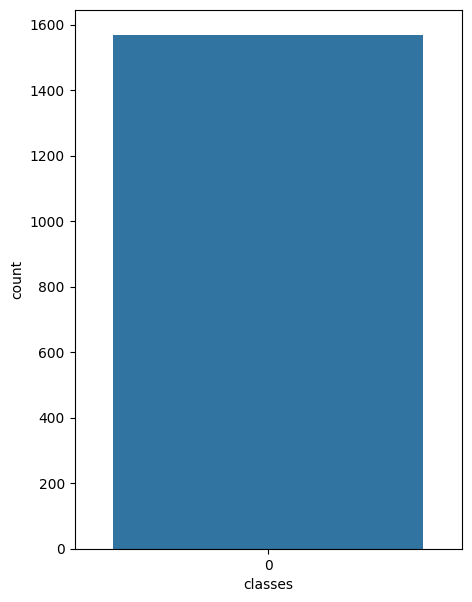

In [ ]:
# Visualize distribution of class
import seaborn as sns
ax = sns.countplot(y_train)
ax.set(xlabel='classes', ylabel='count')
ax.set_xticklabels([1,2,3,4,5,6,7])
plt.show()


In [ ]:
# Modle Evaluation
print("Accuracy:",  accuracy_score(y_test, y_pred))
print("Precision Score : ",precision_score(y_test, y_pred, average='macro'))
print("Recall Score : ",recall_score(y_test, y_pred, average='macro'))
print("F1-Score: ", f1_score(y_test, y_pred, average = 'macro'))

Accuracy: 0.5595238095238095
Precision Score :  0.5145730990908097
Recall Score :  0.491335856494939
F1-Score:  0.4949624195459563


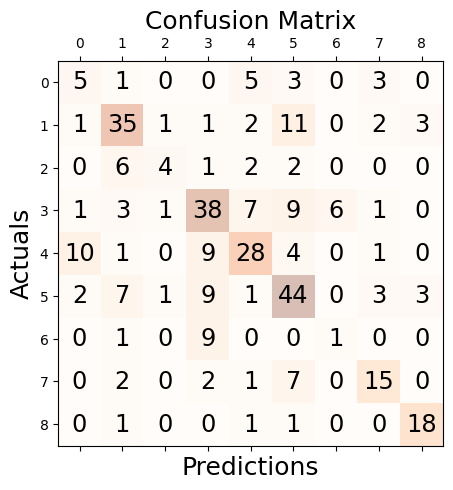

In [ ]:
#Confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Display the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
#Load model
modelLRNormal = keras.models.load_model('modelLRNormal.h5')


#Predict the response for test dataset
y_predLRNormal = np.argmax(modelLRNormal.predict(X_test), axis=-1)



OSError: ignored

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=-1)